In [1]:
## The Baseline Method only use simple gait parameter feature, it only includes 2 dense layers
import scipy.io
import numpy as np
import random

## We delete people's data with low feedback score and remove people who kicked off the sensors during walking'
## So 20 people in total.
person_nums = [1,2,4,5,6,8,9,10,11,12,13,17,19,21,22,25,26,27,28,29]

from feature_emotion import feature_extract, split_data, label_unique_tuples
gts, sensor_nums, walk_nums, trace_nums, people_nums, spe_centr, delta_spe_centr, spe_crest, delta_spe_crest, spe_decrease, delta_spe_decrease, spe_entropy, delta_spe_entropy, spe_flatness, delta_spe_flatness, spe_flux, delta_spe_flux, spe_kurtosis, delta_spe_kurtosis, spe_skewness, delta_spe_skewness, spe_rfp, delta_spe_rfp, spe_slope, delta_spe_slope, spe_spread, delta_spe_spread, wlk_fre, wlk_fres_trace, cwt_figs_all, cwt_sum_all_0, cwt_sum_all_1, cwt_sum_all_2, cwt_sum_all_3, high_fre_compos, pitchs, low_fre_compos, auto_corrs, real_hils, imag_hils, dur_time_1_alls, dur_time_2_alls, jitters, shimmers, jitter_rap, hrs, feature, slope, zcrs, fft_features, energy_alls, log_energy_alls, smoothe_energy_alls, legendres, double_support_time, pdps_new, lpcs, ceps_features = feature_extract(person_nums)

walk_nums_all = np.squeeze(walk_nums)
trace_nums_all = np.squeeze(trace_nums)
people_nums_all = np.squeeze(people_nums)

## 0: train, 1: validation 2: test
flag_tr_val_te = split_data(walk_nums_all, trace_nums_all, people_nums_all)

In [2]:
## Data Normalization before training ans testing
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, LSTM
from sklearn.preprocessing import StandardScaler
scalers = []
X_train_normalized = []
X_val_normalized = []
X_test_normalized = []
train_idx = np.where(flag_tr_val_te ==0)[0]
np.random.shuffle(train_idx)
val_idx = np.where(flag_tr_val_te ==1)[0]
test_idx = np.where(flag_tr_val_te ==2)[0]

for i, feature in enumerate([spe_centr, delta_spe_centr, spe_crest, delta_spe_crest, spe_decrease, delta_spe_decrease, spe_entropy, delta_spe_entropy, spe_flatness, delta_spe_flatness, spe_flux, delta_spe_flux, spe_kurtosis, delta_spe_kurtosis, spe_skewness, delta_spe_skewness, spe_rfp, delta_spe_rfp, spe_slope, delta_spe_slope, spe_spread, delta_spe_spread, wlk_fre, wlk_fres_trace, cwt_figs_all, cwt_sum_all_0, cwt_sum_all_1, cwt_sum_all_2, cwt_sum_all_3, high_fre_compos, pitchs, low_fre_compos, auto_corrs, real_hils, imag_hils, dur_time_1_alls, dur_time_2_alls, jitters, shimmers, jitter_rap, hrs, feature, slope, zcrs, fft_features, energy_alls, log_energy_alls, smoothe_energy_alls, legendres, double_support_time, pdps_new, lpcs, ceps_features]):
    scaler = StandardScaler()
    if len(feature.shape)==2:
        X_train_i = feature[train_idx,:]
        X_val_i = feature[val_idx,:]
        X_test_i = feature[test_idx,:]
        X_train_normalized_i = scaler.fit_transform(X_train_i)
        X_val_normalized_i = scaler.transform(X_val_i)
        X_test_normalized_i = scaler.transform(X_test_i)
        scalers.append(scaler)
    else:
        X_train_i = feature[train_idx,:,:]
        X_val_i = feature[val_idx,:,:]
        X_test_i = feature[test_idx,:,:]
        X_train_normalized_i = scaler.fit_transform(X_train_i.reshape(X_train_i.shape[0], -1)).reshape(X_train_i.shape)
        X_val_normalized_i = scaler.transform(X_val_i.reshape(X_val_i.shape[0], -1)).reshape(X_val_i.shape)
        X_test_normalized_i = scaler.transform(X_test_i.reshape(X_test_i.shape[0], -1)).reshape(X_test_i.shape)
        scalers.append(scaler)
    X_train_normalized.append(X_train_normalized_i)
    X_val_normalized.append(X_val_normalized_i)
    X_test_normalized.append(X_test_normalized_i)
y_train = gts[train_idx,:]
y_val = gts[val_idx,:]
y_test = gts[test_idx,:]

2023-11-27 18:49:22.497089: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
X_train_normalized_new = []
combined_feature = np.empty((len(X_train_normalized[0]),0))
for feature in X_train_normalized:
    if len(feature.shape) == 3:
        X_train_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_train_normalized_new.append(feature)
X_train_normalized_new.append(combined_feature)

X_val_normalized_new = []
combined_feature = np.empty((len(X_val_normalized[0]),0))
for feature in X_val_normalized:
    if len(feature.shape) == 3:
        X_val_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_val_normalized_new.append(feature)
X_val_normalized_new.append(combined_feature)

X_test_normalized_new = []
combined_feature = np.empty((len(X_test_normalized[0]),0))
for feature in X_test_normalized:
    if len(feature.shape) == 3:
        X_test_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_test_normalized_new.append(feature)
X_test_normalized_new.append(combined_feature)

In [4]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_6.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2023-11-27 18:49:56.521489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 18:49:56.533334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 18:49:56.533570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Test MAE:
1.3339769180472065
1.2328533678378875


In [5]:
def get_weight_statistics(layer):
    weights = layer.get_weights()
    num_zeros = 0
    total_weights = 0
    for w in weights:
        num_zeros += np.sum(w == 0)
        total_weights += np.size(w)
    proportion_zeros = num_zeros / total_weights if total_weights != 0 else 0
    return num_zeros, total_weights, proportion_zeros

# Iterate through each layer in the model
for layer in model.layers:
    config = layer.get_config()
    layer_name = config['name']
    if 'dense' in layer_name or 'conv' in layer_name:
        num_zeros, total_weights, proportion_zeros = get_weight_statistics(layer)
        print(f'Layer Name: {layer_name}')
        print(f'Number of Weights with Value 0: {num_zeros}')
        print(f'Total Number of Weights: {total_weights}')
        print(f'Proportion of Weights with Value 0: {proportion_zeros:.4f}\n')

Layer Name: conv2d
Number of Weights with Value 0: 100
Total Number of Weights: 320
Proportion of Weights with Value 0: 0.3125

Layer Name: conv2d_1
Number of Weights with Value 0: 1580
Total Number of Weights: 4624
Proportion of Weights with Value 0: 0.3417

Layer Name: conv2d_2
Number of Weights with Value 0: 43
Total Number of Weights: 136
Proportion of Weights with Value 0: 0.3162

Layer Name: conv2d_3
Number of Weights with Value 0: 11
Total Number of Weights: 36
Proportion of Weights with Value 0: 0.3056

Layer Name: dense
Number of Weights with Value 0: 1513
Total Number of Weights: 4512
Proportion of Weights with Value 0: 0.3353

Layer Name: dense_1
Number of Weights with Value 0: 4491
Total Number of Weights: 13568
Proportion of Weights with Value 0: 0.3310

Layer Name: dense_2
Number of Weights with Value 0: 709
Total Number of Weights: 2080
Proportion of Weights with Value 0: 0.3409

Layer Name: dense_3
Number of Weights with Value 0: 21
Total Number of Weights: 66
Proportio

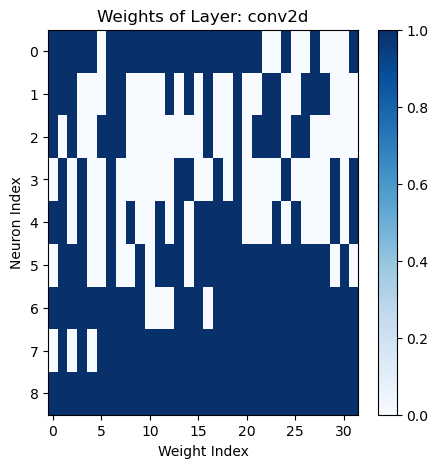

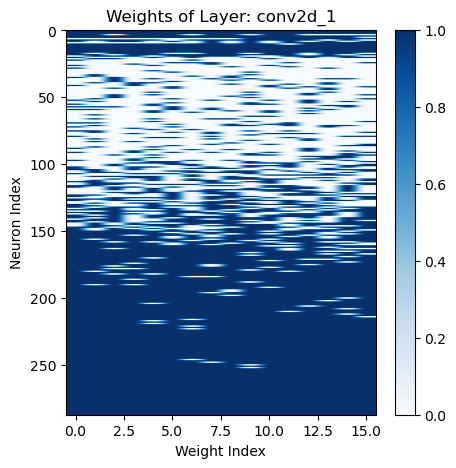

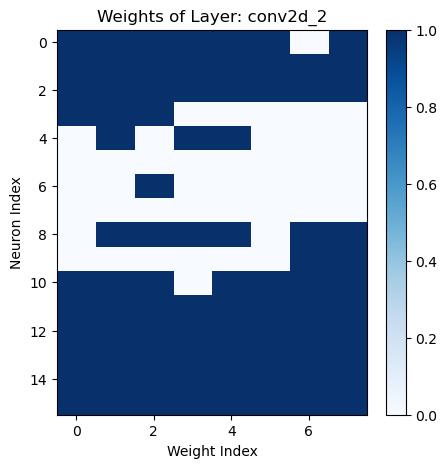

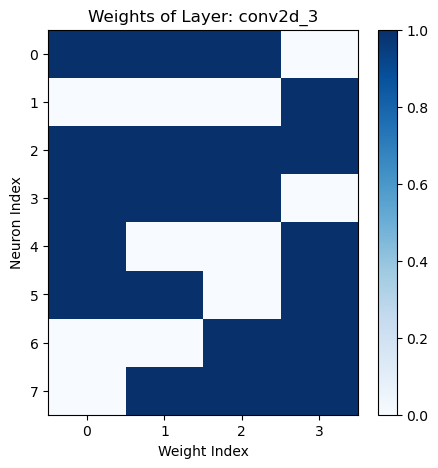

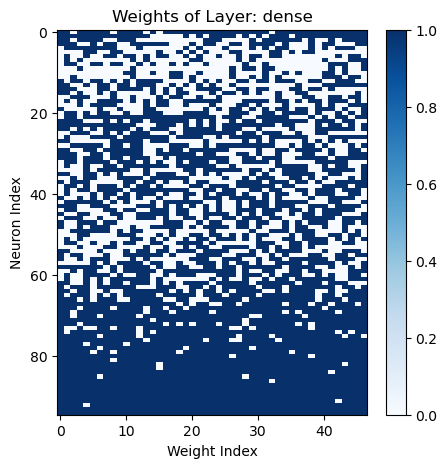

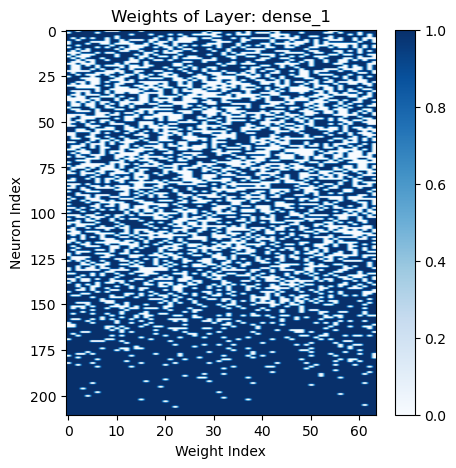

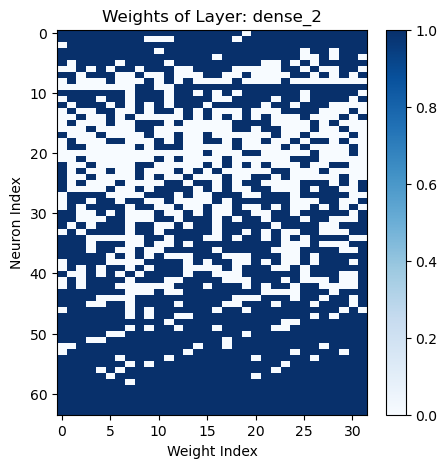

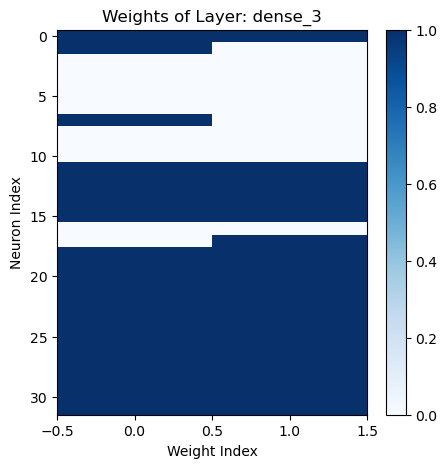

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_layer_weights(layer_weights, layer_name):
    # Assuming the weights are 2D (common for dense layers), or can be reshaped into 2D.
    if len(layer_weights.shape) > 2:
        # Flatten the weights for conv layers
        layer_weights = layer_weights.reshape(-1, layer_weights.shape[-1])

    plt.figure(figsize=(5, 5))
    plt.imshow(layer_weights != 0, cmap='Blues', aspect='auto')
    plt.colorbar()
    plt.title(f"Weights of Layer: {layer_name}")
    plt.xlabel("Weight Index")
    plt.ylabel("Neuron Index")
    plt.show()

# Iterate through each layer in the model
for layer in model.layers:
    config = layer.get_config()
    layer_name = config['name']
    if 'dense' in layer_name or 'conv' in layer_name:
        weights = layer.get_weights()[0]  # Assuming the first element is the weight matrix
        plot_layer_weights(weights, layer_name)


In [7]:
for layer in model.layers:
    config = layer.get_config()
    layer_name = config['name']
    if 'dense' in layer_name or 'conv' in layer_name:
        weights = layer.get_weights()[0]
        print(weights.shape)

(3, 3, 1, 32)
(3, 3, 32, 16)
(1, 1, 16, 8)
(1, 1, 8, 4)
(95, 47)
(211, 64)
(64, 32)
(32, 2)


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 46, 176)]    0           []                               
                                                                                                  
 tf_op_layer_strided_slice (Ten  (None, 46, 176, 1)  0           ['input_23[0][0]']               
 sorFlowOpLayer)                                                                                  
                                                                                                  
 conv2d (Conv2D)                (None, 44, 174, 32)  320         ['tf_op_layer_strided_slice[0][0]
                                                                 ']                               
                                                                                              

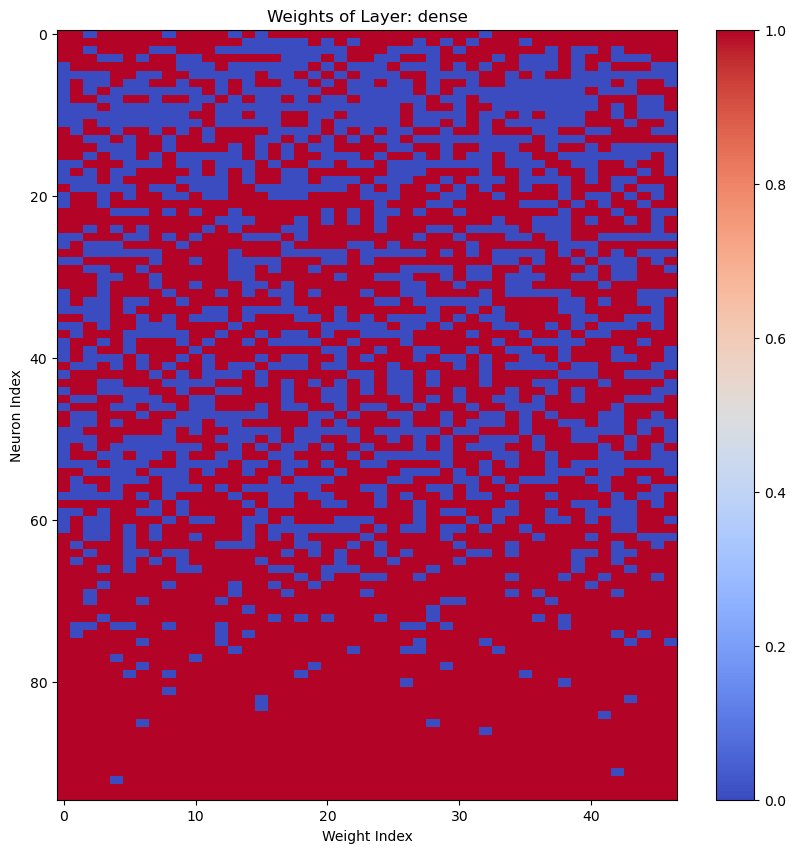

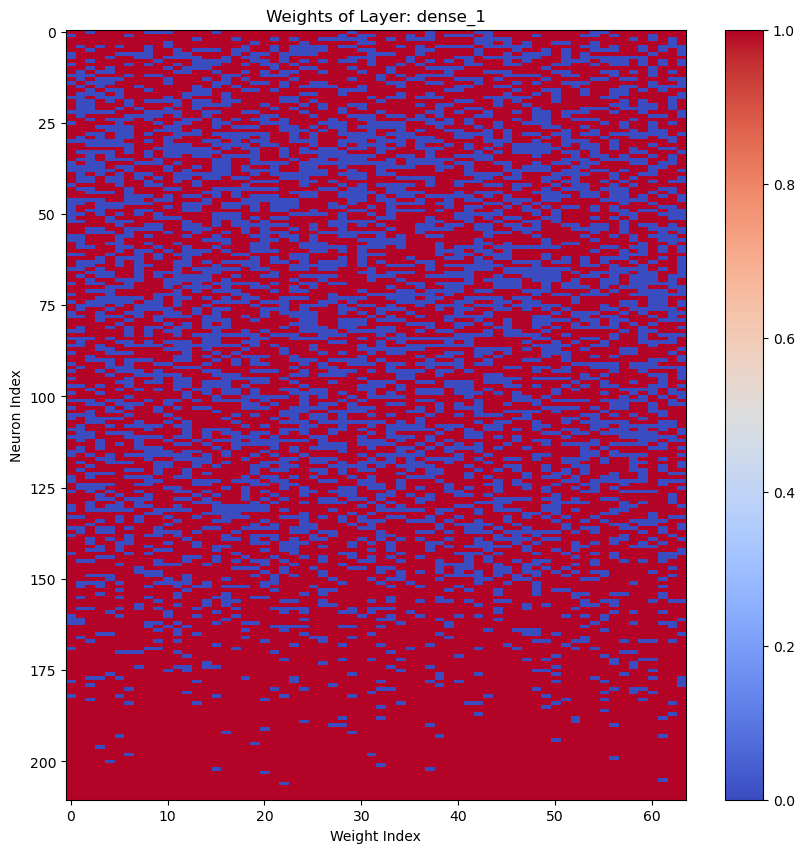

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_layer_weights(layer_weights, layer_name):
    # Assuming the weights are 2D (common for dense layers), or can be reshaped into 2D.
    if len(layer_weights.shape) > 2:
        # Flatten the weights for conv layers
        layer_weights = layer_weights.reshape(-1, layer_weights.shape[-1])

    plt.figure(figsize=(10, 10))
    plt.imshow(layer_weights != 0, cmap='Blues', aspect='auto')
    plt.colorbar()
    plt.title(f"Weights of Layer: {layer_name}")
    plt.xlabel("Weight Index")
    plt.ylabel("Neuron Index")
    plt.show()

# Iterate through each layer in the model
for layer in model.layers:
    config = layer.get_config()
    layer_name = config['name']
    if 'dense_1' in layer_name:
        weights = layer.get_weights()[0]  # Assuming the first element is the weight matrix
        plot_layer_weights(weights, layer_name)
    if layer_name == 'dense':
        weights_pre = layer.get_weights()[0]  # Assuming the first element is the weight matrix
        plot_layer_weights(weights_pre, layer_name)

    if 'conv' in layer_name:
        weights_pre = layer.get_weights()[0]  # Assuming the first element is the weight matrix
        plot_layer_weights(weights_pre, layer_name)


In [69]:
weights_pre_bool = weights_pre != 0
print(weights_pre_bool.shape)

(95, 47)


In [17]:
weights_bool = weights != 0
print(weights_bool.shape)

(211, 64)


In [76]:
weights_bool_sum = np.sum(weights_bool,1)
weights_pre_bool_sum = np.sum(weights_pre_bool,1)

In [59]:
lstm_importance = np.empty((0,1))
cnn_importance = np.empty((0,1))
combined_importance = np.empty((0,1))
for i in range(22):
    tmp_importance = np.mean(weights_bool_sum[i * 4:(i + 1) * 4])/64
    lstm_importance = np.vstack((lstm_importance, tmp_importance))
tmp_importance = np.mean(weights_bool_sum[88:104])/64
cnn_importance = np.vstack((cnn_importance,tmp_importance))
for i in range(15):
    tmp_importance = np.mean(weights_bool_sum[104+i * 4:104+(i + 1) * 4])/64
    lstm_importance = np.vstack((lstm_importance,tmp_importance))
tmp_importance = np.mean(weights_bool_sum[164:])/64
combined_importance = np.vstack((combined_importance,tmp_importance))

In [60]:
lstm_importance.shape

(37, 1)

In [62]:
tmp_importance

0.9365026595744681

In [36]:
len(X_train_normalized)

53

In [57]:
importance.shape

(39, 1)

In [54]:
feature_names = [
    "spe_centr", "delta_spe_centr", "spe_crest", "delta_spe_crest", 
    "spe_decrease", "delta_spe_decrease", "spe_entropy", "delta_spe_entropy", 
    "spe_flatness", "delta_spe_flatness", "spe_flux", "delta_spe_flux", 
    "spe_kurtosis", "delta_spe_kurtosis", "spe_skewness", "delta_spe_skewness", 
    "spe_rfp", "delta_spe_rfp", "spe_slope", "delta_spe_slope", 
    "spe_spread", "delta_spe_spread", "wlk_fre", "wlk_fres_trace", 
    "cwt_figs_all", "cwt_sum_all_0", "cwt_sum_all_1", "cwt_sum_all_2", 
    "cwt_sum_all_3", "high_fre_compos", "pitchs", "low_fre_compos", 
    "auto_corrs", "real_hils", "imag_hils", "dur_time_1_alls", 
    "dur_time_2_alls", "jitters", "shimmers", "jitter_rap", 
    "hrs", "feature", "slope", "zcrs", "fft_features", 
    "energy_alls", "log_energy_alls", "smoothe_energy_alls", 
    "legendres", "double_support_time", "pdps_new", "lpcs", "ceps_features"
]
len(feature_names)

53

In [73]:
lstm_names = []
cnn_names = []
combines_names = []
importance_dict = {}
lstm_i = 0
for i in range(len(X_train_normalized)):
    feature = X_train_normalized[i]
    if len(feature.shape) == 3:
        cnn_names.append(feature_names[i])
        importance_dict[feature_names[i]] = cnn_importance
    elif feature.shape[1] <20:
        combines_names.append(feature_names[i])
    else:
        lstm_names.append(feature_names[i])
        importance_dict[feature_names[i]] = lstm_importance[lstm_i]
        lstm_i += 1
        

In [90]:
names_new = ["Spectral Centroid", "Delta Spectral Centroid", "Spectral Crest", "Delta Spectral Crest",
            "Spectral Decrease", "Delta Spectral Decrease", "Spectral Entropy", "Delta Spectral Entropy",
            "Spectral Flatness", "Delta Spectral Flatness", "Spectral Flux", "Delta Spectral Flux",
            "Spectral Kurtosis", "Delta Spectral Kurtosis", "Spectral Skewness", "Delta Spectral Skewness",
            "Spectral Rolloff Point", "Delta Spectral Rolloff Point", "Spectral Slope", "Delta Spectral Slope",
            "Spectral Spread", "Delta Spectral Spread",  "CWT Contour of >100 Hz band",
            "Pitchs", "CWT Contour of <=100 Hz band", "Autocorrelation", "Hilbert transform (Real)", "Hilbert transform (Imag)",
            "Harmonic Rate", "Zero Crossing Rate", "Fast Fourier transform", "Energy Contour", "Log Energy Contour", "Smoothed Energy Contour",
            "Legendre Coefficients", "Linear Prediction Coefficients", "Cepstrum", "Step Frequency (Method 1)", "Step Frequency (Method 2)", 
            "FWHM of 10 to 35 Hz frequency band", "FWHM of 100 to 250 Hz frequency band", "Jitters", "Shimmers", "Jitter RAP", "Average",
            "Median", "Standard Deviation", "Maximum", "Minimum", "Range", "Skewness", "Kurtosis", "Number of Peaks", "Number of Valleys",
            "Signal Slope", "Double Support Time", "Peak Ratio Between HS and TO","Continuous Wavelet Transform (CWT)"]

In [88]:
importance_dict

{'spe_centr': array([0.765625]),
 'delta_spe_centr': array([0.54296875]),
 'spe_crest': array([0.625]),
 'delta_spe_crest': array([0.62109375]),
 'spe_decrease': array([0.640625]),
 'delta_spe_decrease': array([0.609375]),
 'spe_entropy': array([0.578125]),
 'delta_spe_entropy': array([0.45703125]),
 'spe_flatness': array([0.48828125]),
 'delta_spe_flatness': array([0.4609375]),
 'spe_flux': array([0.578125]),
 'delta_spe_flux': array([0.48046875]),
 'spe_kurtosis': array([0.5546875]),
 'delta_spe_kurtosis': array([0.54296875]),
 'spe_skewness': array([0.58203125]),
 'delta_spe_skewness': array([0.56640625]),
 'spe_rfp': array([0.46875]),
 'delta_spe_rfp': array([0.51953125]),
 'spe_slope': array([0.484375]),
 'delta_spe_slope': array([0.5234375]),
 'spe_spread': array([0.546875]),
 'delta_spe_spread': array([0.5546875]),
 'cwt_figs_all': array([[0.57617188]]),
 'high_fre_compos': array([0.6171875]),
 'pitchs': array([0.50390625]),
 'low_fre_compos': array([0.578125]),
 'auto_corrs': a

In [87]:
importance_dict['cwt_all'] = np.mean([importance_dict['cwt_sum_all_0'], importance_dict['cwt_sum_all_1'], importance_dict['cwt_sum_all_2'], importance_dict['cwt_sum_all_3'], importance_dict['cwt_figs_all']])

In [89]:
importance_dict_tmp = importance_dict
del importance_dict_tmp['cwt_sum_all_0']
del importance_dict_tmp['cwt_sum_all_1']
del importance_dict_tmp['cwt_sum_all_2']
del importance_dict_tmp['cwt_sum_all_3']
del importance_dict_tmp['cwt_figs_all']

In [94]:
key_mapping = dict(zip(importance_dict_tmp.keys(), names_new))

# Initialize a new dictionary to store updated data
updated_data = {}

# Iterate and update keys
for old_key, new_key in key_mapping.items():
    if old_key in importance_dict_tmp:
        updated_data[new_key] = importance_dict_tmp[old_key]

In [97]:
updated_data

{'Spectral Centroid': array([0.765625]),
 'Delta Spectral Centroid': array([0.54296875]),
 'Spectral Crest': array([0.625]),
 'Delta Spectral Crest': array([0.62109375]),
 'Spectral Decrease': array([0.640625]),
 'Delta Spectral Decrease': array([0.609375]),
 'Spectral Entropy': array([0.578125]),
 'Delta Spectral Entropy': array([0.45703125]),
 'Spectral Flatness': array([0.48828125]),
 'Delta Spectral Flatness': array([0.4609375]),
 'Spectral Flux': array([0.578125]),
 'Delta Spectral Flux': array([0.48046875]),
 'Spectral Kurtosis': array([0.5546875]),
 'Delta Spectral Kurtosis': array([0.54296875]),
 'Spectral Skewness': array([0.58203125]),
 'Delta Spectral Skewness': array([0.56640625]),
 'Spectral Rolloff Point': array([0.46875]),
 'Delta Spectral Rolloff Point': array([0.51953125]),
 'Spectral Slope': array([0.484375]),
 'Delta Spectral Slope': array([0.5234375]),
 'Spectral Spread': array([0.546875]),
 'Delta Spectral Spread': array([0.5546875]),
 'CWT Contour of >100 Hz band'

In [79]:
importance_dict['wlk_fre'] = combined_importance * np.mean(weights_pre_bool_sum[0])/47
importance_dict['wlk_fres_trace'] = combined_importance * np.mean(weights_pre_bool_sum[1])/47
importance_dict['cwt_sum_all_0'] = combined_importance * np.mean(weights_pre_bool_sum[2:20])/47
importance_dict['cwt_sum_all_1'] = combined_importance * np.mean(weights_pre_bool_sum[20:38])/47
importance_dict['cwt_sum_all_2'] = combined_importance * np.mean(weights_pre_bool_sum[38:56])/47
importance_dict['cwt_sum_all_3'] = combined_importance * np.mean(weights_pre_bool_sum[56:74])/47
importance_dict['dur_time_1_alls'] = combined_importance * np.mean(weights_pre_bool_sum[74])/47
importance_dict['dur_time_2_alls'] = combined_importance * np.mean(weights_pre_bool_sum[75])/47
importance_dict['jitters'] = combined_importance * np.mean(weights_pre_bool_sum[76])/47
importance_dict['shimmers'] = combined_importance * np.mean(weights_pre_bool_sum[77])/47
importance_dict['jitter_rap'] = combined_importance * np.mean(weights_pre_bool_sum[78])/47
importance_dict['feature_0'] = combined_importance * np.mean(weights_pre_bool_sum[79])/47
importance_dict['feature_1'] = combined_importance * np.mean(weights_pre_bool_sum[80])/47
importance_dict['feature_2'] = combined_importance * np.mean(weights_pre_bool_sum[81])/47
importance_dict['feature_3'] = combined_importance * np.mean(weights_pre_bool_sum[82])/47
importance_dict['feature_4'] = combined_importance * np.mean(weights_pre_bool_sum[83])/47
importance_dict['feature_5'] = combined_importance * np.mean(weights_pre_bool_sum[84])/47
importance_dict['feature_6'] = combined_importance * np.mean(weights_pre_bool_sum[85])/47
importance_dict['feature_7'] = combined_importance * np.mean(weights_pre_bool_sum[86])/47
importance_dict['feature_8'] = combined_importance * np.mean(weights_pre_bool_sum[87])/47
importance_dict['feature_9'] = combined_importance * np.mean(weights_pre_bool_sum[88])/47
importance_dict['slope'] = combined_importance * np.mean(weights_pre_bool_sum[89:93])/47
importance_dict['double_support_time'] = combined_importance * np.mean(weights_pre_bool_sum[93])/47
importance_dict['pdps_new'] = combined_importance * np.mean(weights_pre_bool_sum[94])/47

In [99]:
updated_data

{'Spectral Centroid': array([0.765625]),
 'Delta Spectral Centroid': array([0.54296875]),
 'Spectral Crest': array([0.625]),
 'Delta Spectral Crest': array([0.62109375]),
 'Spectral Decrease': array([0.640625]),
 'Delta Spectral Decrease': array([0.609375]),
 'Spectral Entropy': array([0.578125]),
 'Delta Spectral Entropy': array([0.45703125]),
 'Spectral Flatness': array([0.48828125]),
 'Delta Spectral Flatness': array([0.4609375]),
 'Spectral Flux': array([0.578125]),
 'Delta Spectral Flux': array([0.48046875]),
 'Spectral Kurtosis': array([0.5546875]),
 'Delta Spectral Kurtosis': array([0.54296875]),
 'Spectral Skewness': array([0.58203125]),
 'Delta Spectral Skewness': array([0.56640625]),
 'Spectral Rolloff Point': array([0.46875]),
 'Delta Spectral Rolloff Point': array([0.51953125]),
 'Spectral Slope': array([0.484375]),
 'Delta Spectral Slope': array([0.5234375]),
 'Spectral Spread': array([0.546875]),
 'Delta Spectral Spread': array([0.5546875]),
 'CWT Contour of >100 Hz band'

In [98]:
values

[0.765625,
 0.54296875,
 0.625,
 0.62109375,
 0.640625,
 0.609375,
 0.578125,
 0.45703125,
 0.48828125,
 0.4609375,
 0.578125,
 0.48046875,
 0.5546875,
 0.54296875,
 0.58203125,
 0.56640625,
 0.46875,
 0.51953125,
 0.484375,
 0.5234375,
 0.546875,
 0.5546875,
 0.6171875,
 0.50390625,
 0.578125,
 0.5390625,
 0.6015625,
 0.6328125,
 0.5625,
 0.65234375,
 0.59765625,
 0.671875,
 0.6953125,
 0.69921875,
 0.80078125,
 0.75,
 0.8046875,
 array([0.83687472]),
 array([0.71732119]),
 array([0.83687472]),
 array([0.81694913]),
 array([0.83687472]),
 array([0.89665148]),
 array([0.87672589]),
 array([0.85680031]),
 array([0.89665148]),
 array([0.91657707]),
 array([0.89665148]),
 array([0.91657707]),
 array([0.91657707]),
 array([0.89665148]),
 array([0.91657707]),
 array([0.93650266]),
 array([0.93650266]),
 array([0.92653987]),
 array([0.93650266]),
 array([0.93650266]),
 0.5411991780783161]

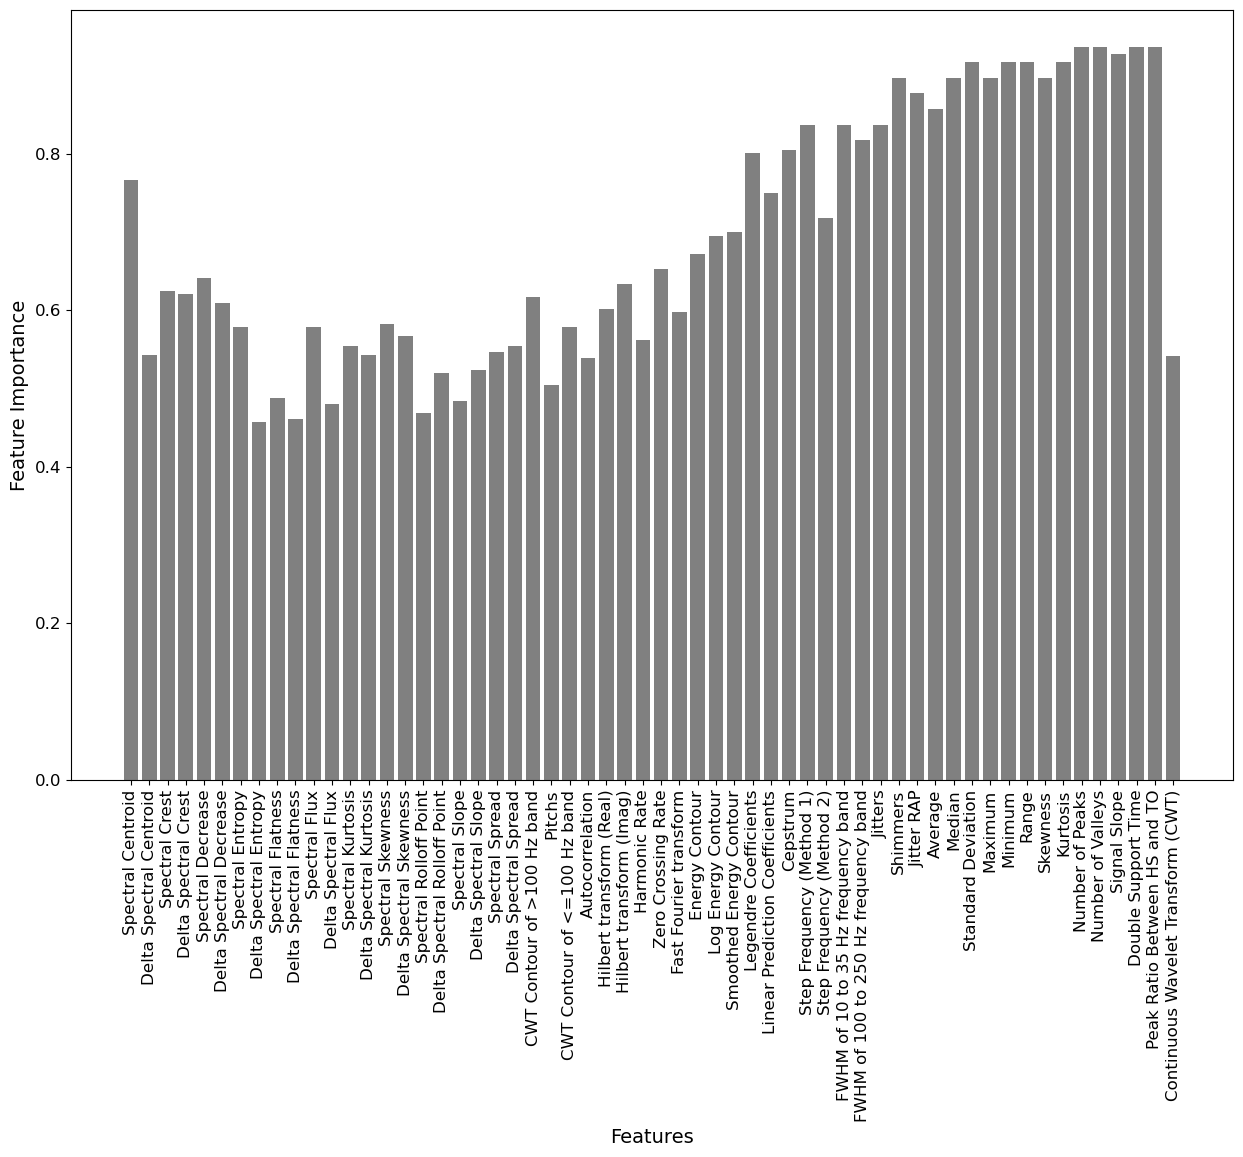

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Your data
data = updated_data

# Preparing the data for plotting
keys = list(data.keys())
values = [np.squeeze(data[key]) if isinstance(data[key], np.ndarray) else data[key] for key in keys]

# Plotting
# Plotting
plt.figure(figsize=(15, 10))  # Adjust the size as per your requirement
plt.bar(keys, values, color='gray')
plt.xticks(rotation=90)  # Rotating the x labels for better readability
plt.tick_params(axis='x', labelsize=12)  # Enlarge x-tick label font size
plt.tick_params(axis='y', labelsize=12)  # Enlarge y-tick label font size
plt.xlabel('Features', fontsize=14)  # Enlarge x-axis label font size
plt.ylabel('Feature Importance', fontsize=14)  # Enlarge y-axis label font size
# plt.title('Bar Plot of Features', fontsize=16)  # Enlarge title font size
directory = "figs"
file_path = os.path.join(directory, "feature_importance.pdf")
plt.savefig(file_path, bbox_inches='tight')
plt.show()


In [101]:
values

[0.765625,
 0.54296875,
 0.625,
 0.62109375,
 0.640625,
 0.609375,
 0.578125,
 0.45703125,
 0.48828125,
 0.4609375,
 0.578125,
 0.48046875,
 0.5546875,
 0.54296875,
 0.58203125,
 0.56640625,
 0.46875,
 0.51953125,
 0.484375,
 0.5234375,
 0.546875,
 0.5546875,
 0.6171875,
 0.50390625,
 0.578125,
 0.5390625,
 0.6015625,
 0.6328125,
 0.5625,
 0.65234375,
 0.59765625,
 0.671875,
 0.6953125,
 0.69921875,
 0.80078125,
 0.75,
 0.8046875,
 array([0.83687472]),
 array([0.71732119]),
 array([0.83687472]),
 array([0.81694913]),
 array([0.83687472]),
 array([0.89665148]),
 array([0.87672589]),
 array([0.85680031]),
 array([0.89665148]),
 array([0.91657707]),
 array([0.89665148]),
 array([0.91657707]),
 array([0.91657707]),
 array([0.89665148]),
 array([0.91657707]),
 array([0.93650266]),
 array([0.93650266]),
 array([0.92653987]),
 array([0.93650266]),
 array([0.93650266]),
 0.5411991780783161]